In [12]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import yaml
from pathlib import Path
import torchvision
import torchvision.transforms as transforms
from PIL import Image
import models

def load_config(run_path):
    """加载配置文件"""
    config_path = Path(run_path) / 'config.yaml'
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
    return config

def load_model(run_path, config):
    """加载模型"""
    model_path = Path(run_path) / 'best_model.pth'
    checkpoint = torch.load(model_path)
    
    # 这里需要根据您的模型结构进行修改
    model = models.create_model(
            config['network']['name'],
            **config['network']['params']
        )
    model.load_state_dict(checkpoint['model'])
    return model

def get_random_cifar_image():
    """从CIFAR-10数据集中随机获取一张图片"""
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), 
                           (0.2023, 0.1994, 0.2010))
    ])
    
    dataset = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=True, transform=transform)
    
    # 随机选择一张图片
    idx = np.random.randint(len(dataset))
    image, label = dataset[idx]
    
    # 获取原始图片（用于显示）
    original_image = torchvision.datasets.CIFAR10(
        root='./data', train=False, download=False, transform=None)[idx][0]
    
    return image, original_image, label

def visualize_conv_filters(model):
    """可视化第一层卷积核"""
    # 获取第一个卷积层
    first_conv_layer = None
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            first_conv_layer = module
            break
    
    if first_conv_layer is None:
        raise ValueError("没有找到卷积层！")
    
    # 获取权重
    weights = first_conv_layer.weight.data.cpu()
    
    # 创建图表
    n_filters = weights.shape[0]
    n_rows = int(np.ceil(np.sqrt(n_filters)))
    n_cols = int(np.ceil(n_filters / n_rows))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    # fig.suptitle("第一层卷积核可视化", fontsize=16)
    
    for i in range(n_filters):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        # 对于RGB卷积核，我们取平均值来显示
        kernel = weights[i].mean(dim=0)
        
        # 归一化到[0,1]范围
        kernel = (kernel - kernel.min()) / (kernel.max() - kernel.min())
        
        ax.imshow(kernel, cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Filter {i+1}')
    
    plt.tight_layout()
    plt.savefig('imgs/conv_filters.png')
    plt.show()
    plt.close()

def visualize_feature_maps(model, image):
    """可视化特征图"""
    # 获取第一个卷积层
    first_conv_layer = None
    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            first_conv_layer = module
            break
    
    if first_conv_layer is None:
        raise ValueError("没有找到卷积层！")
    
    # 创建一个只包含第一层的模型
    class FirstLayerModel(nn.Module):
        def __init__(self, conv_layer):
            super().__init__()
            self.conv = conv_layer
        
        def forward(self, x):
            return self.conv(x)
    
    first_layer_model = FirstLayerModel(first_conv_layer)
    
    # 获取特征图
    with torch.no_grad():
        image = image.unsqueeze(0)  # 添加batch维度
        feature_maps = first_layer_model(image)
    
    # 可视化特征图
    feature_maps = feature_maps.squeeze(0).cpu()
    n_features = feature_maps.shape[0]
    
    n_rows = int(np.ceil(np.sqrt(n_features)))
    n_cols = int(np.ceil(n_features / n_rows))
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 15))
    # fig.suptitle("第一层卷积后的特征图", fontsize=16)
    
    for i in range(n_features):
        row = i // n_cols
        col = i % n_cols
        ax = axes[row, col] if n_rows > 1 else axes[col]
        
        feature_map = feature_maps[i].numpy()
        feature_map = (feature_map - feature_map.min()) / (feature_map.max() - feature_map.min())
        
        ax.imshow(feature_map, cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Feature Map {i+1}')
    
    plt.tight_layout()
    plt.savefig('imgs/feature_maps.png')
    plt.show()
    plt.close()


In [13]:
# 加载配置和模型
path = "/home/blimber/homework/DATA130011-PJ2/runs/20250529_130252"
config = load_config(path)
model = load_model(path, config)
model.eval()

/tmp/ipykernel_2698904/3300149035.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_path)


DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): GELU(approximate='none')
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation1): GELU(approximate='none')
        (conv1): Conv2d(64, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation2): GELU(approximate='none')
        (conv2): Conv2d(96, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(88, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (activation1): GELU(approximate='none')
        (conv1): Conv2d(88

Files already downloaded and verified


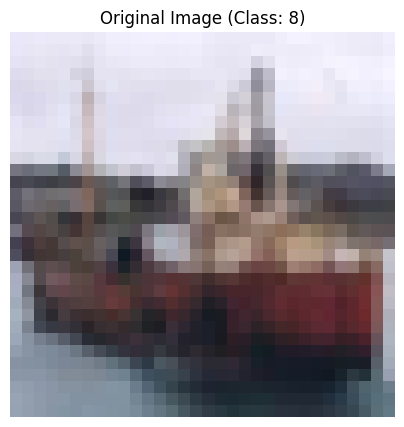

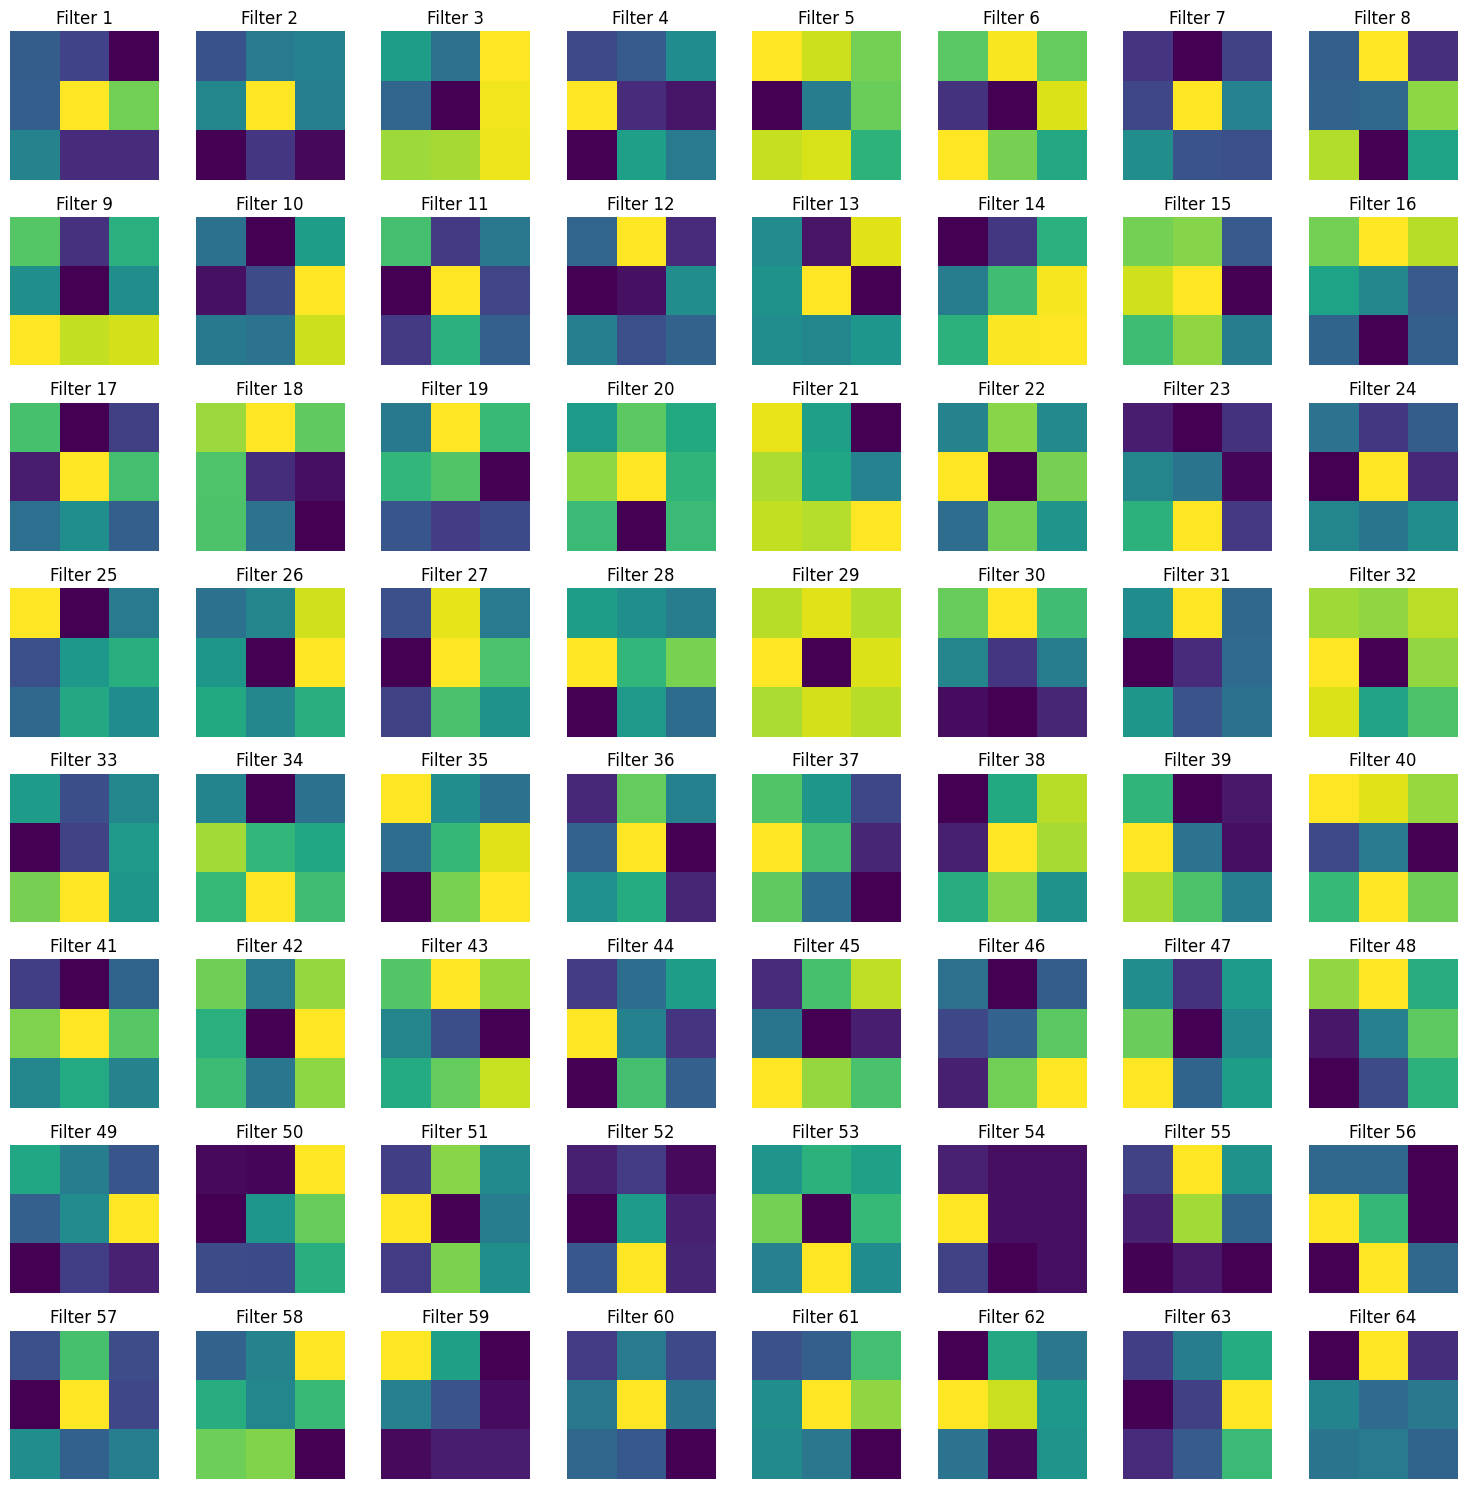

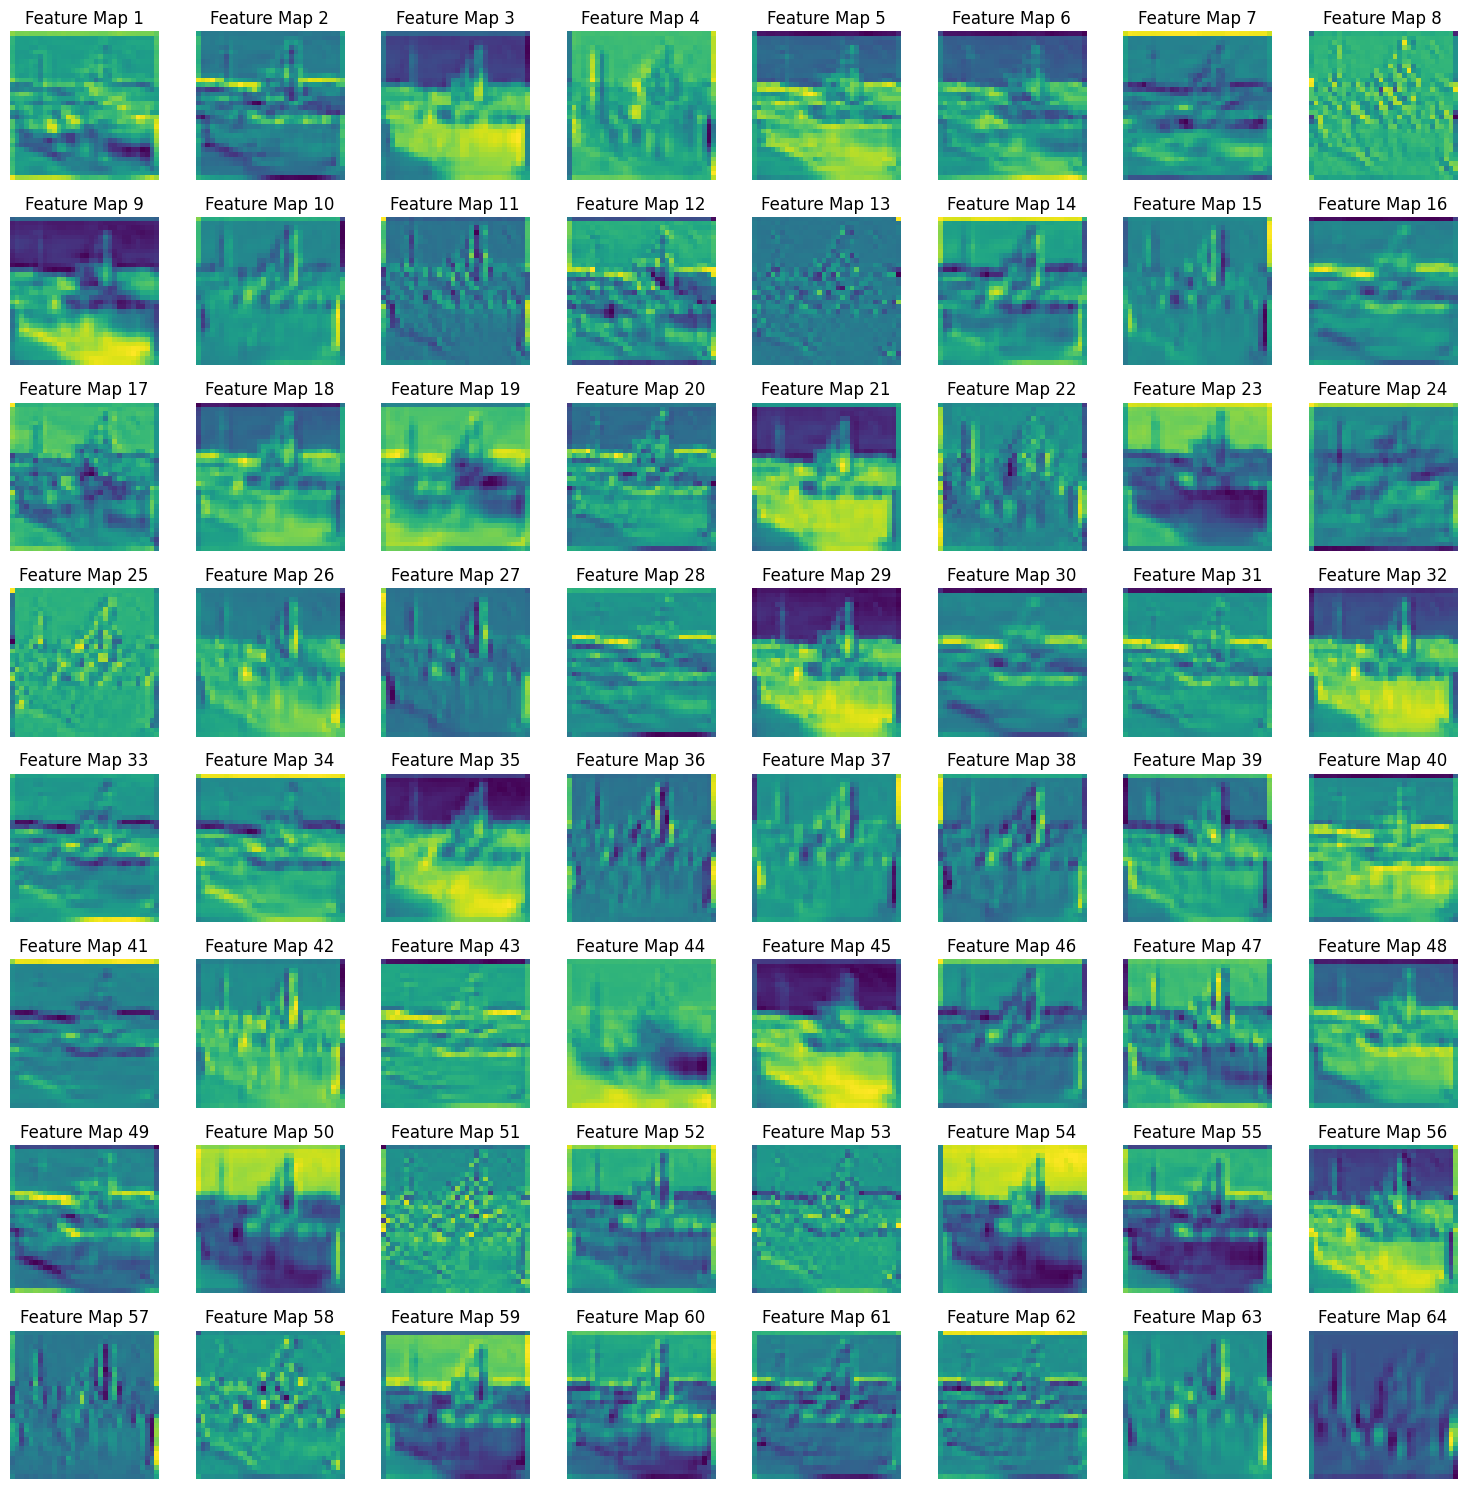

可视化完成！生成了以下文件：
1. original_image.png - 原始CIFAR图片
2. conv_filters.png - 第一层卷积核可视化
3. feature_maps.png - 特征图可视化


In [21]:

# 获取随机CIFAR图片
image, original_image, label = get_random_cifar_image()

# 显示原始图片
plt.figure(figsize=(5, 5))
plt.imshow(original_image)
plt.title(f'Original Image (Class: {label})')
plt.axis('off')
plt.savefig('imgs/original_image.png')
plt.show()
plt.close()

# 可视化卷积核
visualize_conv_filters(model)

# 可视化特征图
visualize_feature_maps(model, image)

print("可视化完成！生成了以下文件：")
print("1. original_image.png - 原始CIFAR图片")
print("2. conv_filters.png - 第一层卷积核可视化")
print("3. feature_maps.png - 特征图可视化")